# Linear SVM Model
Using Linear Support Vector Machine to classify toxic comments

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, classification_report
import matplotlib.pyplot as plt

## Load the data

In [2]:
# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test_1.csv')

print(f"Training data: {train.shape}")
print(f"Test data: {test.shape}")

Training data: (159571, 8)
Test data: (63978, 8)


In [3]:
# Define the labels we want to predict
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Look at the data
print(train.head())
print("\nLabel counts:")
print(train[labels].sum())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  

Label counts:
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

## Convert text to features using TF-IDF
TF-IDF converts text into numerical features that we can use for machine learning

In [4]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))

# Fit on training data and transform both train and test
X_train = vectorizer.fit_transform(train['comment_text'])
X_test = vectorizer.transform(test['comment_text'])

print(f"Feature matrix shape: {X_train.shape}")
print(f"This means we have {X_train.shape[0]} training samples")
print(f"and {X_train.shape[1]} features (words/phrases)")

Feature matrix shape: (159571, 10000)
This means we have 159571 training samples
and 10000 features (words/phrases)


## Train a Linear SVM model for each label
Since we have 6 different labels, we'll train 6 separate models.

We wrap LinearSVC with CalibratedClassifierCV to get probability outputs for ROC-AUC calculation.

In [5]:
# Store our models
models = {}

# Train one model for each label
for label in labels:
    print(f"\nTraining model for {label}...")
    
    # Get the labels for this category
    y_train = train[label]
    
    # Create Linear SVM with calibration for probability estimates
    svm = LinearSVC(C=1.0, class_weight='balanced', max_iter=1000)
    model = CalibratedClassifierCV(svm, cv=3)
    model.fit(X_train, y_train)
    
    # Save the model
    models[label] = model
    
    print(f"Done training {label}")


Training model for toxic...
Done training toxic

Training model for severe_toxic...
Done training severe_toxic

Training model for obscene...
Done training obscene

Training model for threat...
Done training threat

Training model for insult...
Done training insult

Training model for identity_hate...
Done training identity_hate


## Make predictions on test data

In [6]:
# Get predictions for each label
predictions = {}
predictions_proba = {}

for label in labels:
    # Get probability predictions (values between 0 and 1)
    predictions_proba[label] = models[label].predict_proba(X_test)[:, 1]
    # Get binary predictions (0 or 1)
    predictions[label] = models[label].predict(X_test)

print("Predictions complete!")

Predictions complete!


## Evaluate the models
Calculate ROC-AUC score for each label

In [7]:
# Calculate scores
print("Model Performance:\n")
print(f"{'Label':<15} {'ROC-AUC':<10} {'F1-Score':<10}")
print("-" * 35)

auc_scores = []
f1_scores = []

for label in labels:
    # Calculate ROC-AUC (main metric for this dataset)
    auc = roc_auc_score(test[label], predictions_proba[label])
    auc_scores.append(auc)
    
    # Calculate F1 score
    f1 = f1_score(test[label], predictions[label])
    f1_scores.append(f1)
    
    print(f"{label:<15} {auc:<10.4f} {f1:<10.4f}")

print("-" * 35)
print(f"{'Average':<15} {np.mean(auc_scores):<10.4f} {np.mean(f1_scores):<10.4f}")

Model Performance:

Label           ROC-AUC    F1-Score  
-----------------------------------
toxic           0.9417     0.6593    
severe_toxic    0.9682     0.3478    
obscene         0.9520     0.6702    
threat          0.9783     0.3465    
insult          0.9454     0.5855    
identity_hate   0.9482     0.3467    
-----------------------------------
Average         0.9556     0.4927    


## Visualize results

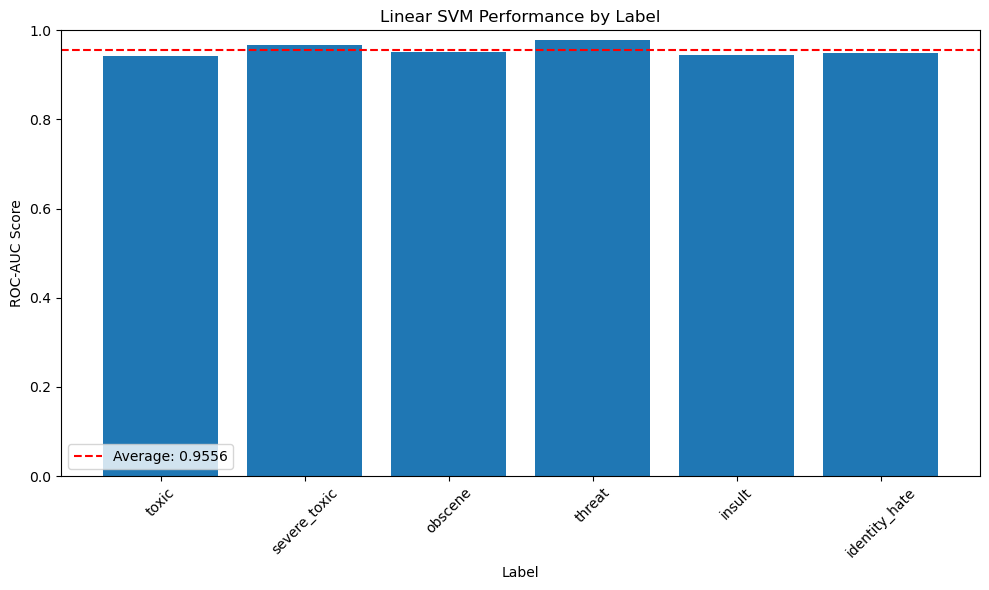

In [8]:
# Plot the ROC-AUC scores
plt.figure(figsize=(10, 6))
plt.bar(labels, auc_scores)
plt.xlabel('Label')
plt.ylabel('ROC-AUC Score')
plt.title('Linear SVM Performance by Label')
plt.xticks(rotation=45)
plt.ylim([0, 1])
plt.axhline(y=np.mean(auc_scores), color='r', linestyle='--', label=f'Average: {np.mean(auc_scores):.4f}')
plt.legend()
plt.tight_layout()
plt.show()

## Look at what words the model learned
Let's see which words are most important for predicting toxicity

In [11]:
# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Look at the toxic label - get coefficients from the base SVM estimator
# CalibratedClassifierCV wraps the base estimators, so we need to access the base_estimator
toxic_model = models['toxic']

# Access coefficients from the calibrated classifiers' base estimators
coefficients = np.mean([est.estimator.coef_[0] for est in toxic_model.calibrated_classifiers_], axis=0)

# Get top 10 most toxic words (highest coefficients)
top_toxic_idx = np.argsort(coefficients)[-10:][::-1]
print("Top 10 words that indicate toxicity:")
for idx in top_toxic_idx:
    print(f"  {feature_names[idx]}: {coefficients[idx]:.2f}")

print("\nTop 10 words that indicate NON-toxicity:")
top_nontoxic_idx = np.argsort(coefficients)[:10]
for idx in top_nontoxic_idx:
    print(f"  {feature_names[idx]}: {coefficients[idx]:.2f}")

Top 10 words that indicate toxicity:
  fuck: 10.83
  fucking: 10.22
  shit: 7.93
  stupid: 7.68
  idiot: 7.62
  bullshit: 7.10
  asshole: 5.78
  ass: 5.51
  sucks: 5.45
  crap: 5.42

Top 10 words that indicate NON-toxicity:
  time for: -2.47
  interested: -2.15
  end up: -2.13
  appreciate: -2.09
  is important: -2.05
  that person: -2.01
  surely: -1.98
  to not: -1.95
  learned: -1.91
  re right: -1.88


## Test on some examples

In [12]:
# Try predicting on a few test examples
print("Some example predictions:\n")

for i in range(5):
    text = test.iloc[i]['comment_text']
    print(f"Comment: {text[:100]}...")
    print(f"True labels: {test.iloc[i][labels].values}")
    print(f"Predicted (toxic): {predictions['toxic'][i]}, Probability: {predictions_proba['toxic'][i]:.3f}")
    print("-" * 80)
    print()

Some example predictions:

Comment: Thank you for understanding. I think very highly of you and would not revert without discussion....
True labels: [np.int64(0) np.int64(0) np.int64(0) np.int64(0) np.int64(0) np.int64(0)]
Predicted (toxic): 0, Probability: 0.015
--------------------------------------------------------------------------------

Comment: :Dear god this site is horrible....
True labels: [np.int64(0) np.int64(0) np.int64(0) np.int64(0) np.int64(0) np.int64(0)]
Predicted (toxic): 1, Probability: 0.630
--------------------------------------------------------------------------------

Comment: "::: Somebody will invariably try to add Religion?  Really??  You mean, the way people have invariab...
True labels: [np.int64(0) np.int64(0) np.int64(0) np.int64(0) np.int64(0) np.int64(0)]
Predicted (toxic): 0, Probability: 0.145
--------------------------------------------------------------------------------

Comment: " 

 It says it right there that it IS a type. The ""Type"" of inst

## Save results

In [13]:
# Save the metrics to a CSV file
results_df = pd.DataFrame({
    'label': labels,
    'roc_auc': auc_scores,
    'f1_score': f1_scores
})

results_df.to_csv('../results/linear_svm_results.csv', index=False)
print("Results saved!")

Results saved!


## Summary

We built a Linear SVM classifier for toxic comments:
1. Used TF-IDF to convert text to features
2. Trained 6 separate Linear SVM models (one per label)
3. Used CalibratedClassifierCV to get probability outputs
4. Evaluated using ROC-AUC scores
5. Looked at which words the model learned are important

### Linear SVM vs Logistic Regression
- Both are linear models that work well with high-dimensional sparse data (like TF-IDF)
- SVM maximizes the margin between classes, while Logistic Regression maximizes likelihood
- SVM can be faster for large datasets
- Logistic Regression gives probabilities directly; SVM needs calibration